In [1]:
using Turing
using DataFrames
using CSV
using Random
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using StatsPlots
using StatsBase
using FreqTables
using Logging

default(label=false)
Logging.disable_logging(Logging.Warn);

# 12.1 Over-dispersed counts

Code 12.1

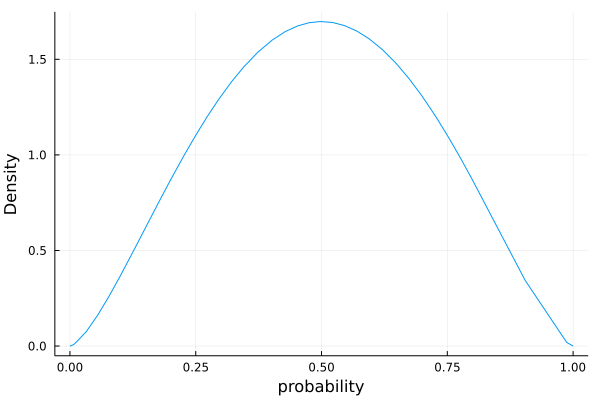

In [8]:
# define alias for Beta(α, β), see: https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_sample_size
Beta2(μ, ν) = Beta(μ*ν, (1-μ)*ν)
BetaBinomial2(n, μ, ν) = BetaBinomial(n, μ*ν, (1-μ)*ν)

p̄ = 0.5
θ = 5
plot(Beta2(p̄, θ), xlab="probability", ylab="Density")

Code 12.2

In [6]:
d = DataFrame(CSV.File("data/UCBadmit.csv", skipto=2, 
        header=[:id, :dept, :gender, :admit, :reject, :applications]))

d.gid = @. ifelse(d.gender == "male", 1, 2)

@model function m12_1(A, N, gid)
    a ~ MvNormal([0, 0], 1.5)
    p̄ = @. exp(a[gid])
    ϕ ~ Exponential(1)
    θ = ϕ + 2
    clamp!(p̄, -Inf, 1.0)    
    @. A ~ BetaBinomial2(N, p̄, θ)
end

Random.seed!(1)
m12_1_ch = sample(m12_1(d.admit, d.applications, d.gid), NUTS(), 1000)
m12_1_df = DataFrame(m12_1_ch);

Code 12.3

In [7]:
m12_1_df.θ = m12_1_df.ϕ .+ 2
m12_1_df.da = m12_1_df."a[1]" .- m12_1_df."a[2]"
precis(m12_1_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│  a[1] │ -0.9924  0.2567  -1.4161  -0.9725  -0.5973       ▁▁▂▄██▅▂▁ │
│  a[2] │ -0.9222  0.2588  -1.3467  -0.9042  -0.5434      ▁▁▁▁▃▇██▃▁ │
│     ϕ │  1.0609  0.8633   0.1117     0.82   2.7159     ██▅▄▂▁▁▁▁▁▁ │
│     θ │  3.0609  0.8633   2.1117     2.82   4.7159     ██▅▄▂▁▁▁▁▁▁ │
│    da │ -0.0702  0.3618  -0.6368   -0.079   0.5297  ▁▁▂▄▆█▇▄▂▂▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘
